# Import libraries

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import json
from torch.optim import lr_scheduler
import time
import os
from PIL import Image
from pathlib import Path
from itertools import chain

from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import * 
from fastai.callbacks import SaveModelCallback
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get most probable category
def getpreds(learn, filesave):
    preds,y = learn.get_preds(ds_type = DatasetType.Test)
    y = torch.argmax(preds,dim=1)
    test_file = pd.Series([str(i)[105:] for i in learn.data.test_dl.dataset.items]).rename('filename')
    test_cat = pd.Series(y).rename('category')
    test_df = pd.concat((test_file, test_cat), axis = 1)
    test_csv = pd.read_csv(path+'/test.csv')
    test_df = test_df[test_df.filename.isin(list(test_csv.filename))].set_index('filename')
    (pd.DataFrame(test_df.category.apply(lambda x: '0'+str(x) if x < 10 else str(x)))).to_csv(filesave)
    
# Get probabilities per category
def predsdf(learn, filename):
    preds,y = learn.get_preds(ds_type = DatasetType.Test)
    test_pd = pd.DataFrame(np.array(preds))
    test_pd.columns = ['0'+str(x) if x < 10 else str(x) for x in range(0,42)]
    test_pd.loc[:, 'filename'] = [str(i)[105:] for i in learn.data.test_dl.dataset.items]
    test_csv = pd.read_csv(path+'/test.csv')
    test_pd = test_pd[test_pd.filename.isin(list(test_csv.filename))].set_index('filename')
    test_pd.to_csv(filename)

# Patricia Bata

## Inception V3

In [2]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()

In [3]:
#Define transforms
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))

In [5]:
# Batch size
bs = 32

# Databunch
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=299, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)

# Get add test to data
data.add_test(Path(path+'/test/').ls())

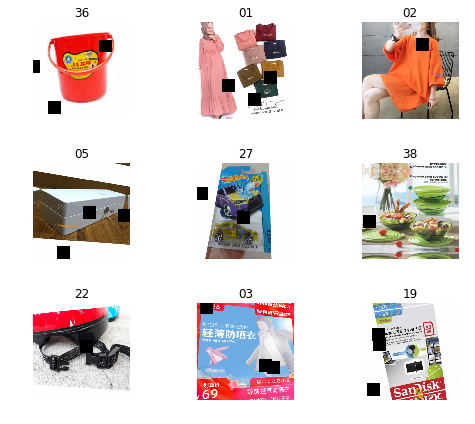

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [8]:
print(data.classes)
len(data.classes),data.c

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


(42, 42)

In [7]:
model = torchvision.models.inception_v3(pretrained = True, aux_logits=False)
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

In [8]:
learn = Learner(data, model, metrics = error_rate)

In [9]:
learn.model.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [38]:
learn.fit_one_cycle(30)

Exception ignored in: <function _ConnectionBase.__del__ at 0x00000284C5DCCF28>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 132, in __del__
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid


In [39]:
learn.save('inceptionv3_cutout_e30')

In [12]:
learn.load('inceptionv3_cutout_e30')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
03,03,03,03,03
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
39,05,10,23,15
Path: \Users\pbata\Documents\pbata files (personal)\Shopee Code League\C02_Product_Detection\SCL_C02_data;

Test: None, model=Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track

In [14]:
predsdf(learn, 'probs_inceptionv3_cutout_e30_preds.csv')

## Resnet50

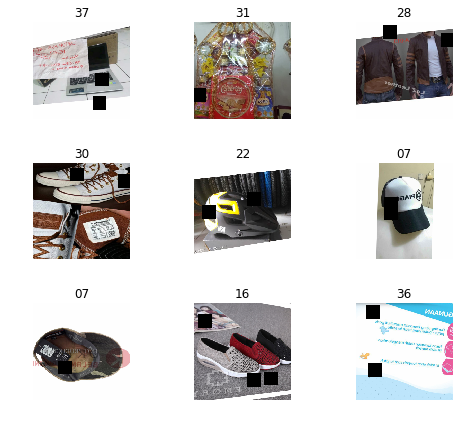

In [2]:
# Do 90 epochs while doing callback

# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
bs = 32

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=280, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data.add_test(Path(path+'/test/').ls())

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [3]:
# Define learner and active cuda
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [4]:
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], tot_epochs = 150, start_epoch = 0)
learn.save('bestmodel_35')

Better model found at epoch 0 with error_rate value: 0.2951418459415436.
Better model found at epoch 1 with error_rate value: 0.2749786376953125.
Better model found at epoch 2 with error_rate value: 0.26216909289360046.
Better model found at epoch 3 with error_rate value: 0.25377169251441956.
Better model found at epoch 4 with error_rate value: 0.24826833605766296.
Better model found at epoch 5 with error_rate value: 0.24238543212413788.
Better model found at epoch 6 with error_rate value: 0.24134168028831482.
Better model found at epoch 7 with error_rate value: 0.23877976834774017.
Better model found at epoch 8 with error_rate value: 0.2364550679922104.
Better model found at epoch 9 with error_rate value: 0.23322895169258118.
Better model found at epoch 11 with error_rate value: 0.23038238286972046.
Better model found at epoch 12 with error_rate value: 0.2269665002822876.
Better model found at epoch 14 with error_rate value: 0.22554321587085724.
Better model found at epoch 15 with err

RuntimeError: CUDA error: unknown error

In [4]:
learn.load('bestmodel_35')
learn.fit_one_cycle(55, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 36)

Loaded bestmodel_35


Better model found at epoch 36 with error_rate value: 0.20784704387187958.
Better model found at epoch 37 with error_rate value: 0.2051427960395813.
Better model found at epoch 39 with error_rate value: 0.20500047504901886.
Better model found at epoch 40 with error_rate value: 0.20428882539272308.
Better model found at epoch 41 with error_rate value: 0.20253345370292664.
Better model found at epoch 42 with error_rate value: 0.19978176057338715.
Better model found at epoch 43 with error_rate value: 0.1987854689359665.
Better model found at epoch 44 with error_rate value: 0.19707752764225006.
Better model found at epoch 46 with error_rate value: 0.19669798016548157.
Better model found at epoch 47 with error_rate value: 0.19532214105129242.


In [4]:
learn.load('bestmodel_54')
learn.fit_one_cycle(90, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 55)

Loaded bestmodel_54


Better model found at epoch 55 with error_rate value: 0.20229622721672058.
Better model found at epoch 62 with error_rate value: 0.20139482617378235.
Better model found at epoch 65 with error_rate value: 0.19869057834148407.
Better model found at epoch 70 with error_rate value: 0.19674542546272278.
Better model found at epoch 71 with error_rate value: 0.1964607685804367.
Better model found at epoch 72 with error_rate value: 0.196033775806427.
Better model found at epoch 75 with error_rate value: 0.19508492946624756.
Better model found at epoch 77 with error_rate value: 0.19418351352214813.
Better model found at epoch 80 with error_rate value: 0.19385141134262085.
Better model found at epoch 81 with error_rate value: 0.19233323633670807.
Better model found at epoch 82 with error_rate value: 0.19219091534614563.
Better model found at epoch 83 with error_rate value: 0.19195368885993958.
Better model found at epoch 85 with error_rate value: 0.19147926568984985.


In [5]:
learn.save('bestmodel_89')

In [4]:
learn.fit_one_cycle(105, callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate')], start_epoch = 90)

Loaded bestmodel_89


Better model found at epoch 90 with error_rate value: 0.19271278381347656.
Better model found at epoch 92 with error_rate value: 0.1924755722284317.
Better model found at epoch 94 with error_rate value: 0.19223834574222565.
Better model found at epoch 95 with error_rate value: 0.1920011341571808.
Better model found at epoch 98 with error_rate value: 0.19157415628433228.
Better model found at epoch 99 with error_rate value: 0.19143182039260864.


In [7]:
# Get probabilities
predsdf(learn, 'probs_resnet50_105e_co.csv')

## Efficientnet B4

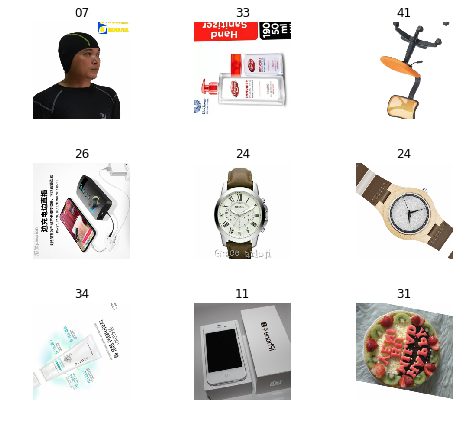

In [2]:
# Define where to data bunch
path = '/Users/pbata/Documents/pbata files (personal)/Shopee Code League/C02_Product_Detection/SCL_C02_data/'
train_df = pd.read_csv(path+'train.csv').rename(columns={'category':'label'})
train_df.label = ['0' + str(x) if x <10 else str(x) for x in train_df.label]
train_df.loc[:,'name'] = train_df.apply(lambda x: 'train/'+str(x.label)+'/'+str(x.filename), axis = 1)
train_df.drop('filename', axis = 1, inplace = True)
train_df = train_df.set_index('name').reset_index()
# bs = 16

# Do cutout on data and databunch
tfms = get_transforms(xtra_tfms = cutout(n_holes=(1,3)))
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
# tfms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
# data = ImageDataBunch.from_df(path, train_df, ds_tfms=tfms, size=224, bs=bs, seed = 2020, valid_pct = 0.2).normalize(imagenet_stats)
data = ImageDataBunch.from_df(df=train_df,
                              path=path,
                              valid_pct=0.1,
                              ds_tfms=get_transforms(flip_vert=True, max_warp=0.1, max_zoom=1.15, max_rotate=45.),
                              size=224,
                              bs=16, 
                              num_workers=os.cpu_count()
                             ).normalize(aptos19_stats)

data.add_test(Path(path+'/test/').ls())

# Show the data
data.show_batch(rows=3, figsize=(7,6))

In [3]:
# check classes
print(f'Classes: {data.classes}')

Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41']


In [5]:
# package_path = '../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master'
# sys.path.append(package_path)
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
nf = data.c # number of output classes in your data
model.fc = nn.Linear(in_features=2048, out_features=nf) # replace fc layer

Loaded pretrained weights for efficientnet-b4


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [7]:
# build model (using EfficientNet)
learn = Learner(data, model,
                loss_func=FocalLoss(),
                metrics=[accuracy,error_rate, KappaScore(weights="quadratic")],
                callback_fns=[BnFreeze,
#                               OverSamplingCallback,
#                               partial(GradientClipping, clip=0.2),
                              partial(SaveModelCallback, monitor='kappa_score', name='best_kappa')]
               )
learn.model.cuda()
learn.split( lambda m: (model._conv_head,) )
learn.freeze()
learn.model_dir = '/tmp/'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.20E-02


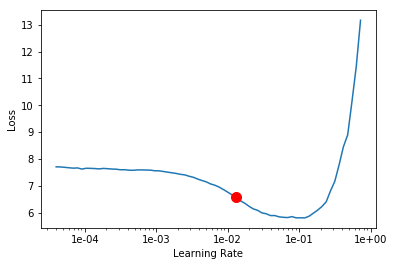

In [6]:
# train head first
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

Better model found at epoch 0 with kappa_score value: 0.752790093421936.


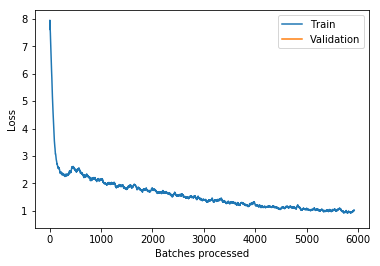

In [7]:
learn.fit_one_cycle(1, max_lr=1.5e-2, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))
learn.save('stage-1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 8.32E-05


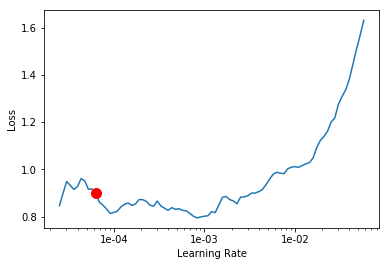

In [8]:
# unfreeze and search appropriate learning rate for full training
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

Better model found at epoch 0 with kappa_score value: 0.7556211352348328.
Better model found at epoch 1 with kappa_score value: 0.7968552708625793.
Better model found at epoch 2 with kappa_score value: 0.8085045218467712.


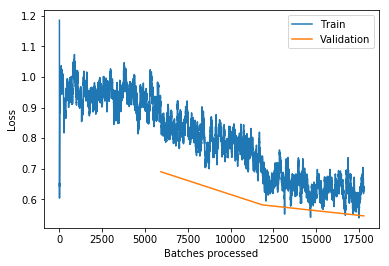

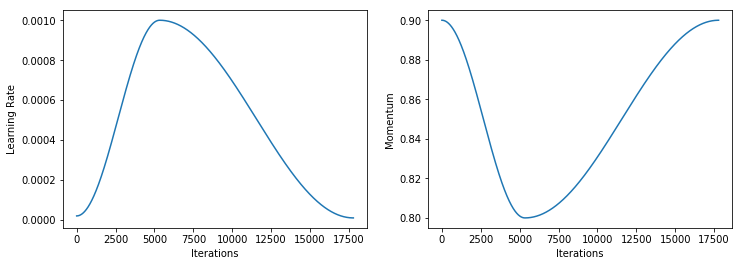

In [9]:
# train all layers
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

Better model found at epoch 0 with kappa_score value: 0.7921796441078186.
Better model found at epoch 1 with kappa_score value: 0.8065789937973022.
Better model found at epoch 2 with kappa_score value: 0.8170773983001709.
Better model found at epoch 3 with kappa_score value: 0.8192899823188782.
Better model found at epoch 5 with kappa_score value: 0.8253146409988403.
Better model found at epoch 6 with kappa_score value: 0.8259310126304626.
Better model found at epoch 7 with kappa_score value: 0.8262786865234375.


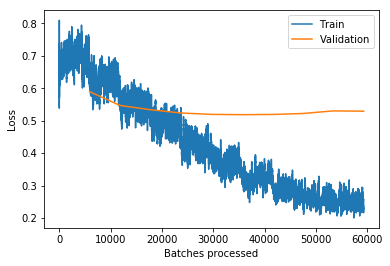

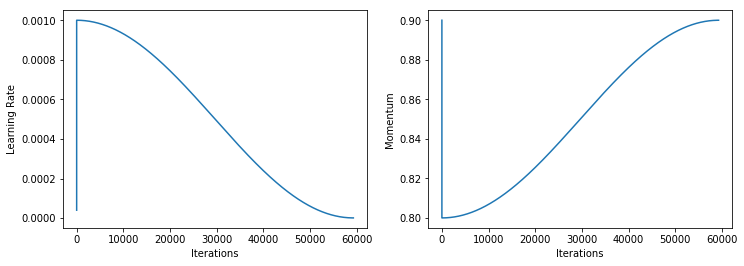

In [10]:
# train all layers
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

Better model found at epoch 0 with kappa_score value: 0.8342515826225281.
Better model found at epoch 2 with kappa_score value: 0.8380177617073059.
Better model found at epoch 5 with kappa_score value: 0.8395971655845642.
Better model found at epoch 13 with kappa_score value: 0.8411100506782532.


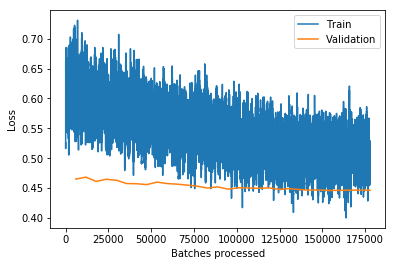

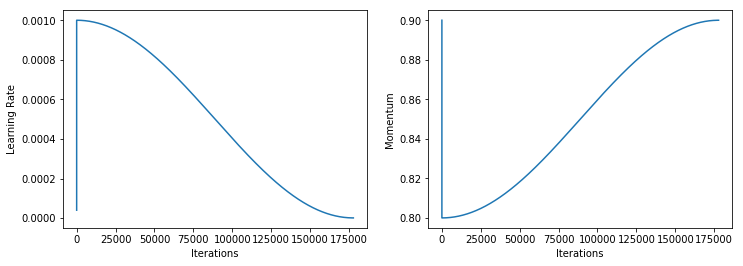

In [8]:
# train all layers
learn.load('stage-2')
learn.fit_one_cycle(cyc_len=30, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-4')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

In [11]:
# remove zoom from FastAI TTA
learn.load('best_kappa')
tta_params = {'beta':0.12, 'scale':1.0}
preds,y = learn.TTA(ds_type=DatasetType.Test, **tta_params)

In [43]:
test_pd = pd.DataFrame(np.array(preds)).iloc[:,0:42]
test_pd.columns = ['0'+str(x) if x < 10 else str(x) for x in range(0,42)]
test_pd.loc[:, 'filename'] = [str(i)[105:] for i in learn.data.test_dl.dataset.items]
test_csv = pd.read_csv(path+'/test.csv')
test_pd = test_pd[test_pd.filename.isin(list(test_csv.filename))].set_index('filename')
test_pd.to_csv('probs_efficientnetb4.csv')

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 232, in _feed
    close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times



# Peter Onglao

## Create sample df

In [5]:
path = os.sys.path[0]
path_img = path + '/SCL_C02_data'
np.random.seed(2020)

In [6]:
samp_pct = 0.01

df_train = pd.read_csv(path_img+'/train.csv')
dict_labels = dict(zip([str(x) for x in range(10)],['0' + str(x) for x in range(10)]))
df_train['category'] = df_train.category.astype(str).replace(dict_labels)
df_train['filename'] = 'train' + '/' + df_train.category + '/' + df_train.filename
df_train.columns = ['name','label']
df_sample = df_train.groupby('label', group_keys = False).apply(lambda x: x.sample(frac = samp_pct, random_state = 2020))
display(
    pd.concat(
        [df_train.label.value_counts(normalize = True).rename('Train'),
         df_sample.label.value_counts(normalize = True).rename('Sample')],
        axis = 1
    ).T
)

df_test = pd.read_csv(path_img+'/test.csv')
df_test['filename'] = 'test' + '/' + df_test.filename
df_test.columns = ['name','label']

00        01        02        03        04        05        06  \
Train   0.025457  0.025638  0.025495  0.025647  0.025647  0.025059  0.025059   
Sample  0.025544  0.025544  0.025544  0.025544  0.025544  0.024598  0.024598   

              07        08        09  ...        32        33        34  \
Train   0.025239  0.025619  0.025600  ...  0.020466  0.005437  0.024660   
Sample  0.025544  0.025544  0.025544  ...  0.020814  0.005676  0.024598   

              35        36        37        38        39        40        41  
Train   0.025220  0.025486  0.016367  0.025362  0.025410  0.025438  0.025258  
Sample  0.025544  0.025544  0.016083  0.025544  0.025544  0.025544  0.025544  

[2 rows x 42 columns]

In [7]:
np.random.seed(2020)
df_sample = df_train.groupby('label', group_keys = False).apply(lambda x: x.sample(min(1250,len(x))))

In [8]:
def save_preds(learn, filename = '31GB_peter_x.csv', path = os.sys.path[0]):
    preds,y = learn.get_preds(ds_type = DatasetType.Test)
    y = torch.argmax(preds, dim=1)
    df_test_preds = pd.concat([pd.Series([str(x)[66:] for x in learn.data.test_dl.dataset.items]), pd.Series(y)], axis = 1)
    df_test_preds.columns = ['filename','category']
    df_test_preds = df_test_preds[df_test_preds.filename.isin(globals()['df_test'].name.str[5:])].set_index('filename')
    df_test_preds['category'] = df_test_preds['category'].apply(lambda x: '0' + str(x) if x < 10 else str(x))
    df_test_preds.to_csv(path + '/' + filename)

## Full Data

In [45]:
bs = 32

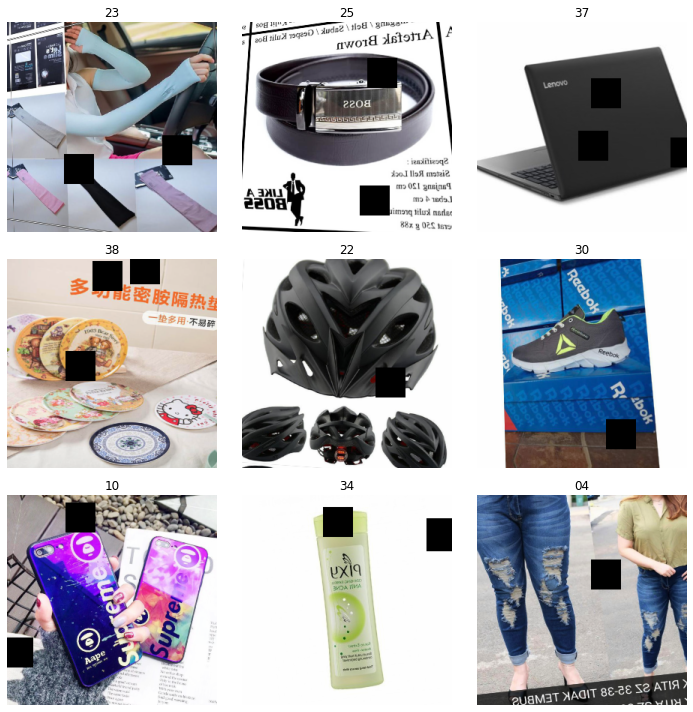

In [46]:
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = tfms, size = 280, bs = bs).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

#### Mixup & Smoothing, Full Data, Many Epochs, ResNet50

In [47]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate, loss_func = LabelSmoothingCrossEntropy()).mixup()

In [48]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [15]:
start = 0
learn.fit_one_cycle(50, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_50te_cutmix_ls')])

RuntimeError: CUDA error: unknown error

In [14]:
start = 24
learn.fit_one_cycle(50, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_50te_cutmix_ls')])

Loaded resnet50_50te_cutmix_ls_23


In [54]:
save_preds(learn, filename = '31GB_peter_'+'resnet50_50te_cutmix_ls'+'.csv')

In [56]:
start = 50
learn.fit_one_cycle(70, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_50te_cutmix_ls')])

Loaded resnet50_50te_cutmix_ls_49


In [49]:
learn.load('resnet50_50te_cutmix_ls_69')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3):

In [52]:
predsdf(learn,'probs_resnet50_50te_cutmix_ls_69.csv')

#### Probs for ResNet50

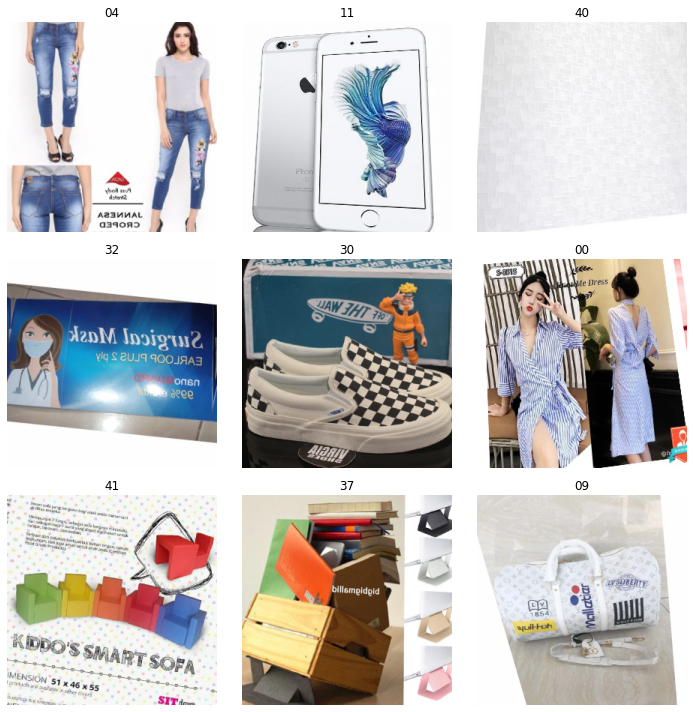

In [25]:
bs = 32
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = get_transforms(), size = 280, bs = bs).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

In [26]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.model.cuda()
learn.load('resnet50_30e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3):

In [30]:
predsdf(learn,'resnet50_30e_peter.csv')

#### Probs for ResNet 152

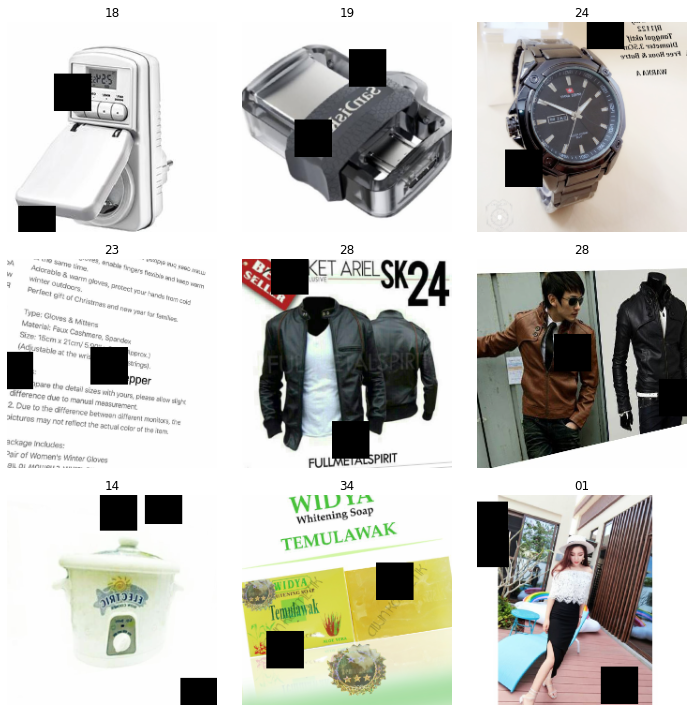

In [31]:
bs = 16
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = tfms, size = 224, bs = bs).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

In [32]:
learn = cnn_learner(data, models.resnet152, metrics = error_rate)
learn.model.cuda()
learn.load('resnet152_20e_90te_cutout')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3):

In [33]:
predsdf(learn,'resnet152_20e_90te_cutout_peter.csv')

#### ResNet 152

In [12]:
learn = cnn_learner(data, models.resnet152, metrics = error_rate)

In [12]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [10]:
# learn.fit_one_cycle(10)

In [11]:
# learn.save('resnet152_10e_cutout')

#### Fit continuous cycle

In [21]:
for start in range(0,90,10):
    if start != 0:
        learn.load(save_str)
        learn.unfreeze()
    learn.fit_one_cycle(10, tot_epochs = 90, start_epoch = start)
    end = start + 10
    save_str = 'resnet152_{}e_90te_cutout'.format(end)
    learn.save(save_str)
    print('Saved: {}'.format(save_str))
    save_preds(learn, filename = '31GB_peter_'+save_str+'.csv')

Saved: resnet152_10e_90te_cutout


Saved: resnet152_20e_90te_cutout


Saved: resnet152_30e_90te_cutout


Saved: resnet152_40e_90te_cutout


Saved: resnet152_50e_90te_cutout


Saved: resnet152_60e_90te_cutout


Saved: resnet152_70e_90te_cutout


Saved: resnet152_80e_90te_cutout


Saved: resnet152_90e_90te_cutout


In [14]:
start = 10
learn.fit_one_cycle(90-start, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet152_10e_90te_cutout')])

Loaded resnet152_10e_90te_cutout_9


KeyboardInterrupt: 

In [17]:
start = 0
learn.fit_one_cycle(90, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet152_90te_cutout_mu_ls')])

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002D866D519D8>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "C:\ProgramData\Anaconda3\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

## Full Data, ResNet50

In [17]:
bs = 32

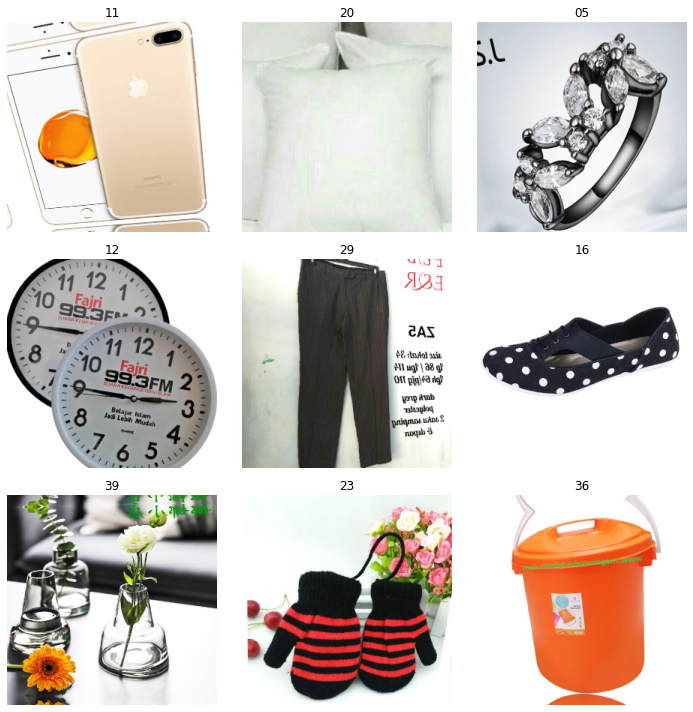

In [8]:
data = ImageDataBunch.from_df(path = path_img, df = df_train, seed = 2020, valid_pct = 0.2, ds_tfms = get_transforms(), size = 280, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [10]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [11]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


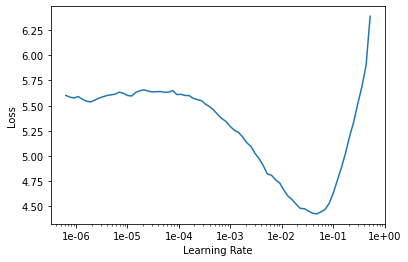

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(10, max_lr = slice(1e-6,2e-3))

In [14]:
learn.save('resnet50_10e')

### Results

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

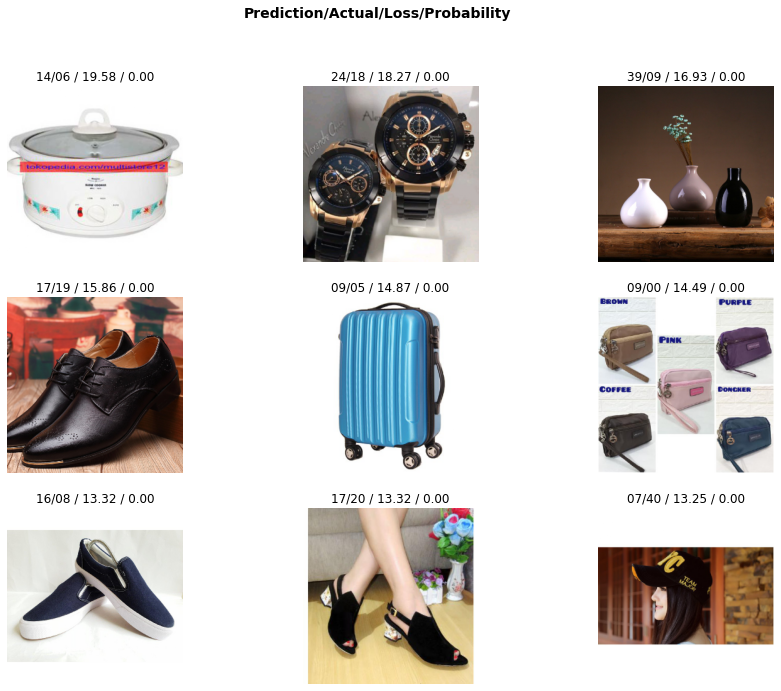

In [16]:
interp.plot_top_losses(9, figsize = (15,11))

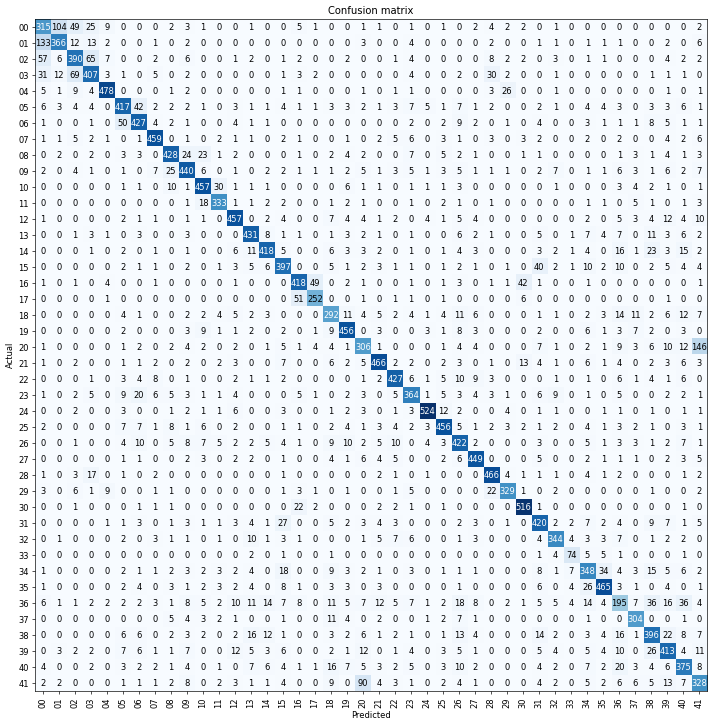

In [17]:
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60)

In [18]:
interp.most_confused(min_val = 2)

[('20', '41', 146),
 ('01', '00', 133),
 ('00', '01', 104),
 ('41', '20', 90),
 ('03', '02', 69),
 ('02', '03', 65),
 ('02', '00', 57),
 ('17', '16', 51),
 ('06', '05', 50),
 ('00', '02', 49),
 ('16', '17', 49),
 ('05', '06', 42),
 ('16', '30', 42),
 ('15', '31', 40),
 ('36', '38', 36),
 ('36', '40', 36),
 ('34', '35', 34),
 ('03', '00', 31),
 ('03', '28', 30),
 ('10', '11', 30),
 ('31', '15', 27),
 ('04', '29', 26),
 ('35', '34', 26),
 ('39', '38', 26),
 ('00', '03', 25),
 ('09', '08', 25),
 ('08', '09', 24),
 ('08', '10', 23),
 ('14', '38', 23),
 ('29', '28', 22),
 ('30', '16', 22),
 ('38', '39', 22),
 ('23', '06', 20),
 ('40', '36', 20),
 ('11', '10', 18),
 ('34', '15', 18),
 ('36', '26', 18),
 ('28', '03', 17),
 ('14', '36', 16),
 ('36', '39', 16),
 ('38', '13', 16),
 ('38', '36', 16),
 ('40', '18', 16),
 ('14', '40', 15),
 ('34', '38', 15),
 ('18', '36', 14),
 ('36', '14', 14),
 ('36', '34', 14),
 ('38', '31', 14),
 ('01', '03', 13),
 ('21', '30', 13),
 ('38', '26', 13),
 ('41', '

## Fit More

In [9]:
learn.load('resnet50_10e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNor

In [10]:
learn.fit_one_cycle(4, max_lr = slice(1e-6,2e-3))

In [11]:
learn.save('resnet50_14e')

In [12]:
learn.fit_one_cycle(6, max_lr = slice(1e-6,2e-3))

In [13]:
learn.save('resnet50_20e')

In [19]:
learn.load('resnet50_20e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
03,03,03,03,03
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
39,05,10,23,15
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNor

In [20]:
learn.fit_one_cycle(10, max_lr = slice(1e-6,2e-3))

In [21]:
learn.save('resnet50_30e')

### Get predictions

In [6]:
bs = 32

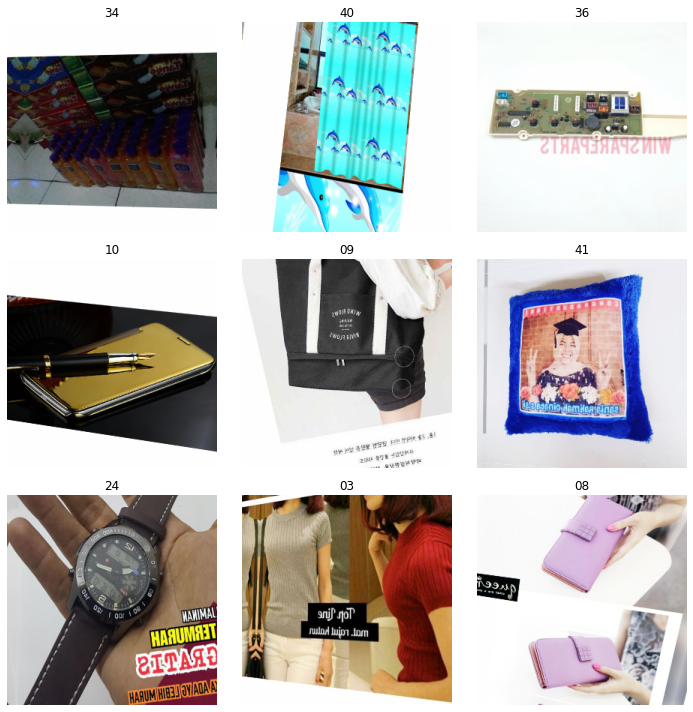

In [7]:
data = ImageDataBunch.from_folder(path = path_img, test = 'test', seed = 2020, valid_pct = 0.2, ds_tfms = get_transforms(), size = 280, bs = bs).normalize(imagenet_stats)
data.show_batch(rows = 3, figsize = (10,10))

In [8]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

In [9]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [10]:
learn.load('resnet50_20e')

Learner(data=ImageDataBunch;

Train: LabelList (84314 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
00,00,00,00,00
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Valid: LabelList (21078 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: CategoryList
29,05,14,34,34
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data;

Test: LabelList (12192 items)
x: ImageList
Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280),Image (3, 280, 280)
y: EmptyLabelList
,,,,
Path: C:\Users\ponglao\Desktop\Shopee Code League\C02\SCL_C02_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3):

In [11]:
preds,y = learn.get_preds(ds_type = DatasetType.Test)

In [12]:
y = torch.argmax(preds, dim=1)

In [15]:
df_test_preds = pd.concat([pd.Series([str(x)[66:] for x in data.test_dl.dataset.items]), pd.Series(y)], axis = 1)
df_test_preds.columns = ['filename','category']
df_test_preds = df_test_preds[df_test_preds.filename.isin(df_test.name.str[5:])].set_index('filename')
df_test_preds.to_csv(path + '/31GB_peter_02_resnet50_20e.csv')

## ResNet50 with CutMix

In [16]:
from fastai.callbacks.mixup import MixUpCallback, MixUpLoss

class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y,self.true_λ = alpha,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y, true_λ=true_λ))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix

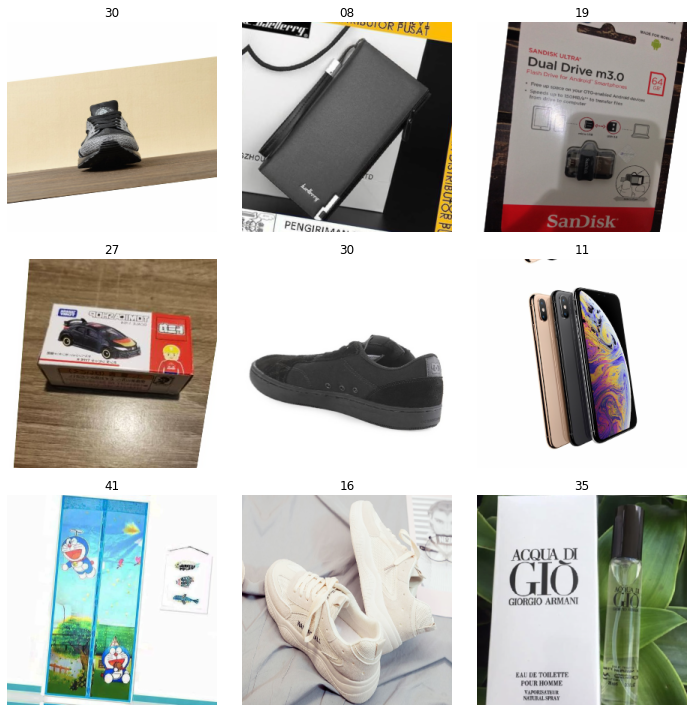

In [14]:
bs = 32
data = ImageDataBunch.from_df(ds_tfms = get_transforms(),
                              path = path_img, 
                              df = df_train, 
                              seed = 2020, 
                              valid_pct = 0.2, 
                              size = 280, 
                              bs = bs).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

In [17]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate).cutmix()

In [18]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [19]:
start = 0
learn.fit_one_cycle(30, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_30te_realcutmix')])

In [20]:
predsdf(learn,'probs_resnet50_30te_realcutmix.csv')

## ResNet50 No Transforms

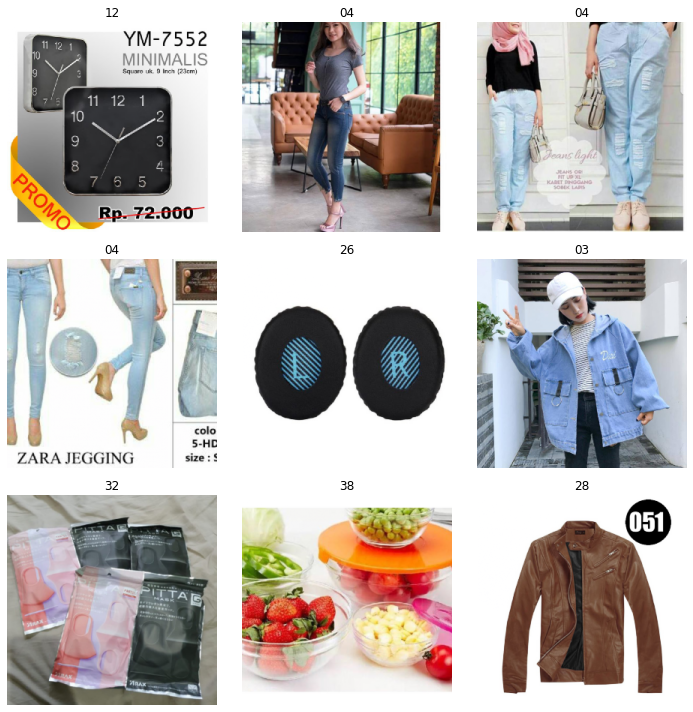

In [9]:
# Other transforms:
bs = 32
# aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
# get_transforms(flip_vert=False, max_warp=0.1, max_zoom=1.15, max_rotate=45.)
data = ImageDataBunch.from_df(df=df_train,
                              path=path_img,
                              valid_pct=0.2,
                              ds_tfms=None,
                              size=280,
                              bs=bs, 
                             ).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

In [11]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)
learn.model.cuda()
start = 4
learn.fit_one_cycle(30, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,s
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_30te_notrans')])

Loaded resnet50_30te_notrans_3


In [12]:
predsdf(learn,'probs_resnet50_30te_notrans.csv')

## RS50 with Mixup

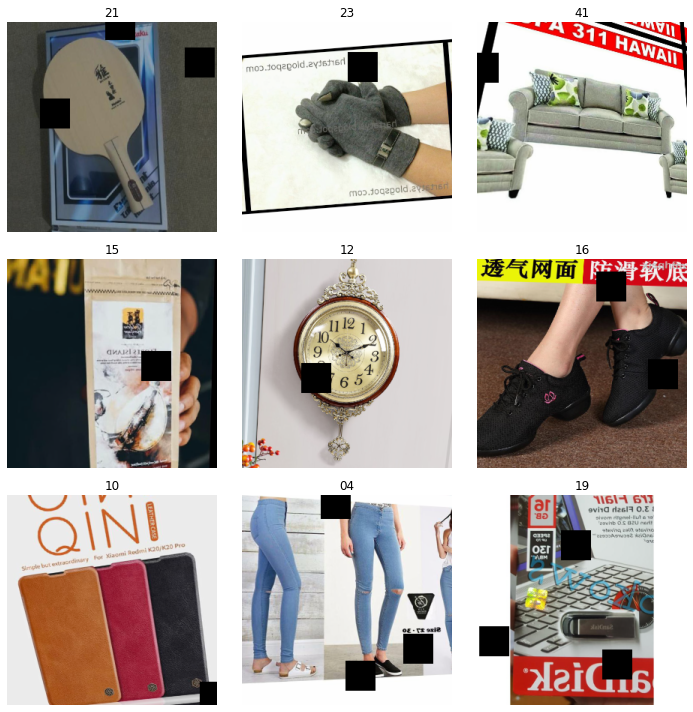

In [13]:
# Other transforms:
bs = 32
# aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])
# get_transforms(flip_vert=False, max_warp=0.1, max_zoom=1.15, max_rotate=45.)
data = ImageDataBunch.from_df(df=df_train,
                              path=path_img,
                              valid_pct=0.2,
                              ds_tfms=tfms,
                              size=280,
                              bs=bs, 
                             ).normalize(imagenet_stats)
data.add_test((Path(path_img+'/test/')).ls())
data.show_batch(rows = 3, figsize = (10,10))

In [16]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate).mixup()
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [17]:
start = 22
learn.fit_one_cycle(30, start_epoch = start,
                    callbacks=[SaveModelCallback(learn,
                                                 every='epoch',
                                                 monitor='error_rate',
                                                 name='resnet50_30te_cutout_mixup')])

Loaded resnet50_30te_cutout_mixup_21


In [18]:
predsdf(learn,'probs_resnet50_30te_cutout_mixup.csv')

# Ensembling

In [21]:
from glob import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [22]:
probs_file_names = glob('probs_*.csv')
# probs_file_names = [f for f in probs_file_names if 'cutmix_ls' not in f]
probs = []
for file_name in probs_file_names:
    temp = pd.read_csv(file_name).set_index('filename')
    temp = (temp-temp.values.mean())/(temp.values.std())
    if file_name != probs_file_names[0]:
        temp = temp.reindex_like(probs[0])
    probs.append(temp)

In [23]:
[(prob>0).sum().sum() for prob in probs]

[46110, 247646, 20584, 35176, 27189, 32313, 40962, 26845, 242611, 263767]

In [24]:
[(prob>0.5).sum().sum() for prob in probs]

[21508, 140246, 15791, 19976, 17721, 19080, 20170, 17694, 137762, 159425]

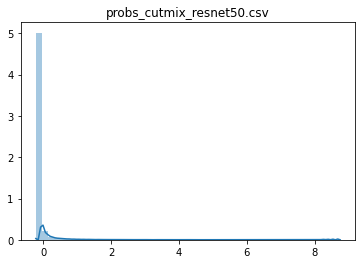

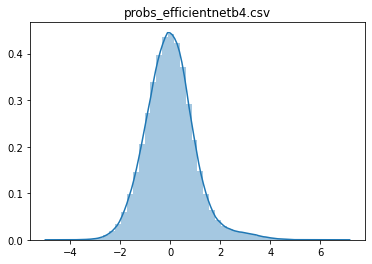

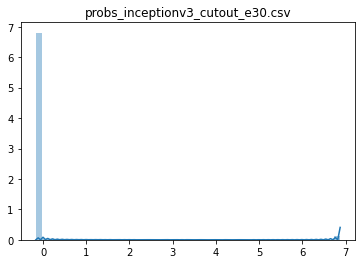

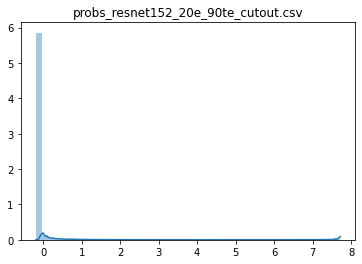

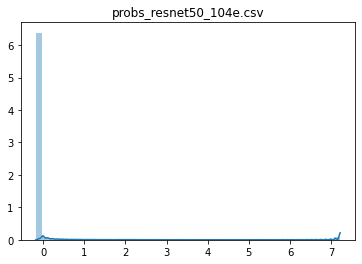

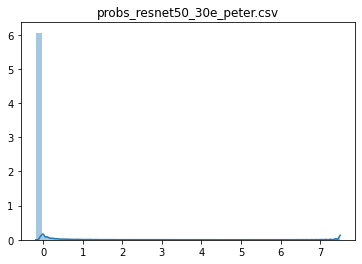

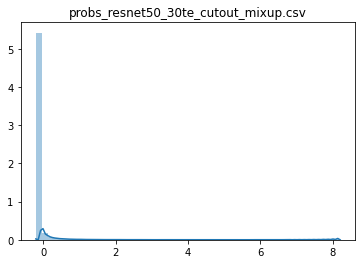

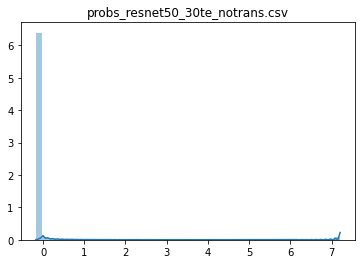

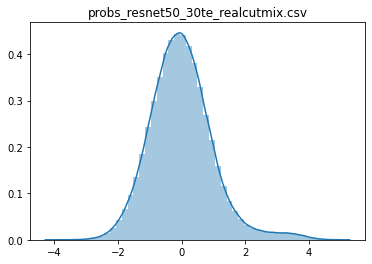

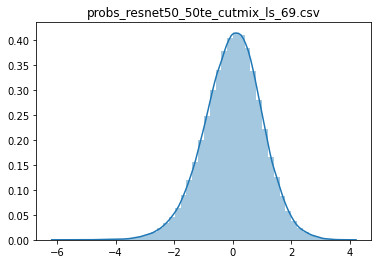

In [26]:
for fname, prob in zip(probs_file_names, probs):
    sns.distplot(prob.stack())
    plt.title(fname)
    plt.show()

Model averaging

In [27]:
probs = sum(probs[2:6])/len(probs[2:6])
pd.DataFrame(probs.idxmax(axis = 1).rename('category')).to_csv('31GB_ensemble_inception_rs50x2_rs152.csv')